In [1]:
%matplotlib inline

In [2]:
import sys
import os
import pickle
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

In [3]:
import datetime
print(datetime.datetime.now())

2020-08-23 15:44:27.713114


In [4]:
resolution = 200

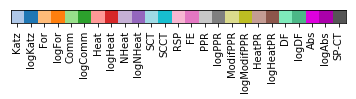

In [5]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [6]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
dataset = []
for fn in tqdm(os.listdir(root)):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                param_best_ari = sorted(parameter_results, key=lambda x: -x['modularity'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    dataset.append((item, data['info']))

In [7]:
# generate additional features
for item in dataset:
    maxari = np.max(list(item[0].values()))
    item[1]['maxari'] = maxari

In [8]:
dataset[0]

({'Katz': 0.14996624517575394,
  'logKatz': 0.5193299856257373,
  'For': 0.0011173506031268595,
  'logFor': 0.3024887837235861,
  'Comm': 0.16567514363400482,
  'logComm': 0.0035317351479401365,
  'Heat': 0.002180717894255135,
  'logHeat': 0.006806338574892867,
  'NHeat': 0.17312470182104747,
  'logNHeat': 0.43315085919519475,
  'SCT': 0.832240624582806,
  'SCCT': 0.7995099236358044,
  'RSP': 0.6852221455465335,
  'FE': 0.4361064096048135,
  'PPR': 0.029088803390801624,
  'logPPR': 0.44133319871441584,
  'ModifPPR': 0.0011173506031268595,
  'logModifPPR': 0.44133319871441584,
  'HeatPR': 0.08895130139054652,
  'logHeatPR': 0.43315085919519475,
  'DF': 0.14996624517575394,
  'logDF': 0.007269355084528752,
  'Abs': 0.0011173506031268595,
  'logAbs': 0.4219296607565311,
  'SP-CT': 0.6808830997082841},
 {'name': 'LFR',
  'n': 1372,
  'k': 6,
  'tau1': 4.364389787820993,
  'tau2': 3.7891391078489134,
  'mu': 0.48695112200547785,
  'average_degree': 208.2668132822028,
  'min_degree': None,
 

# My own knn

In [9]:
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = np.argsort(pair_distance[test_idx])[:self.n_neighbors]
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)
    
    
class MyFilter:
    def __init__(self, distance=0.05):
        self.max_distance = distance
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < self.max_distance:
                    chosen_indices.append(train_idx)
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx] * (self.max_distance - pair_distance[test_idx, chosen_idx])
            output.append(weighted_results)
        return np.array(output)
    
    
class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)

# Plot knn of two features

In [10]:
all_feature_names = [
    'n',
    'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'min_community',
    'maxari'
]

fnc = {
    'n': lambda x: x/1500,
    'k': lambda x: ((1 - 1/x) - 0.5) * 2,
    'tau1': lambda x: ((1 - 1/x) - 0.19) * 1.35,
    'tau2': lambda x: ((1 - 1/x) - 0.),
    'mu': lambda x: x,
    'average_degree': lambda x: x/750,
    'min_community': lambda x: x/700,
    'maxari': lambda x: x,
    'modularity': lambda x: (x + 0.5) / 2
}

real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')
  
# real_limits['tau1'] = (1, 200)
# real_limits['tau2'] = (1, 200)
# limits['tau1'] = (0, 0.99)
# limits['tau2'] = (0, 0.99)
    
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * resolution

n: 10.00, 1499.00 | 0.01, 1.00
k: 2.00, 224.00 | 0.00, 0.99
tau1: 1.25, 20.00 | 0.01, 1.03
tau2: 1.01, 198.88 | 0.01, 0.99
mu: 0.02, 1.00 | 0.02, 1.00
average_degree: 1.11, 748.48 | 0.00, 1.00
min_community: 1.00, 702.00 | 0.00, 1.00
maxari: 0.01, 1.00 | 0.01, 1.00


In [11]:
kernels_order = [x.name for x in kernels]
kernels_order

['Katz',
 'logKatz',
 'For',
 'logFor',
 'Comm',
 'logComm',
 'Heat',
 'logHeat',
 'NHeat',
 'logNHeat',
 'SCT',
 'SCCT',
 'RSP',
 'FE',
 'PPR',
 'logPPR',
 'ModifPPR',
 'logModifPPR',
 'HeatPR',
 'logHeatPR',
 'DF',
 'logDF',
 'Abs',
 'logAbs',
 'SP-CT']

In [12]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([sorted(item[0].items(), key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_myknn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyKNN(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

In [13]:
def doplot(ax, X, y, plot, feature_names):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[1]][0], real_limits[feature_names[1]][1], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[0]][0], real_limits[feature_names[0]][1], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

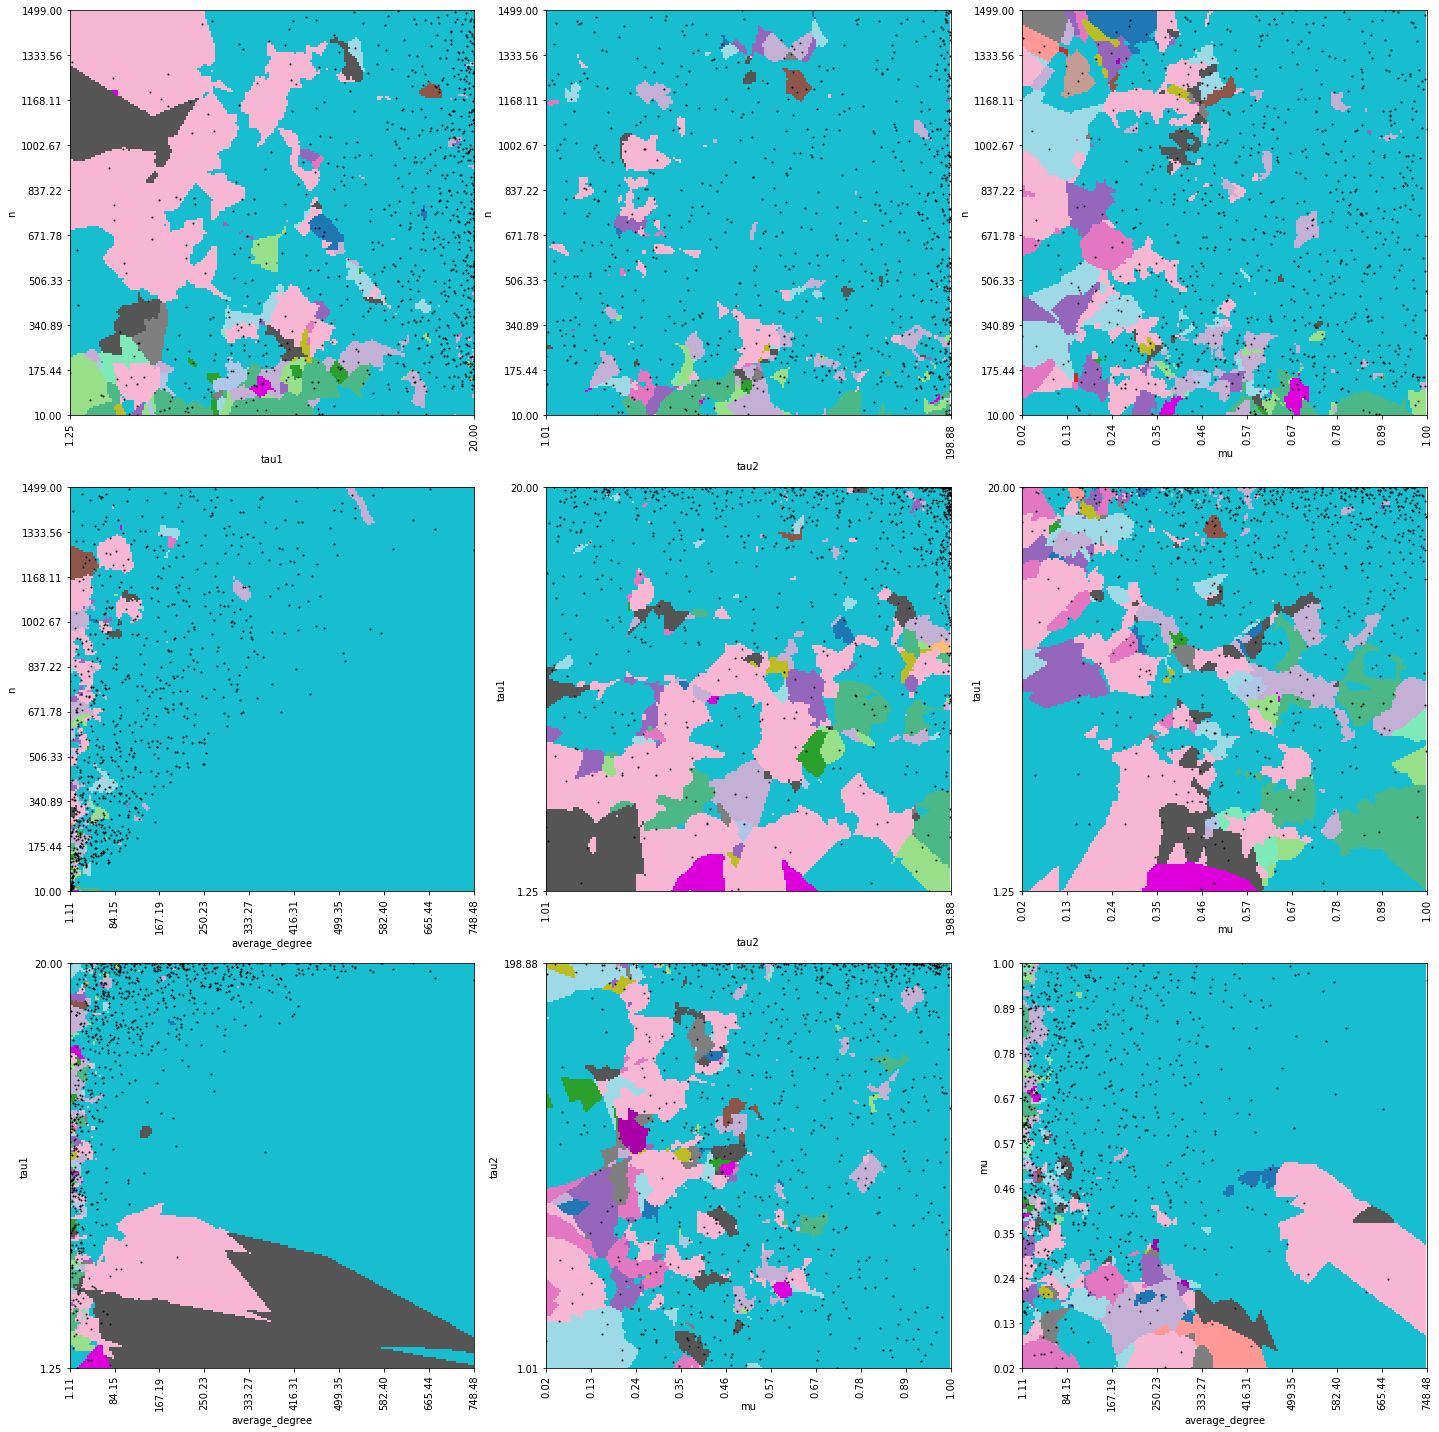

In [14]:
n_neighbors = 5

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['n', 'tau2']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'mu']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'average_degree']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau1', 'tau2']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau1', 'mu']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'average_degree']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][0], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][1], X, y, plot, feature_names)

feature_names = ['mu', 'average_degree']
X, y, plot = prepare_plot_myknn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][2], X, y, plot, feature_names)

plt.tight_layout()

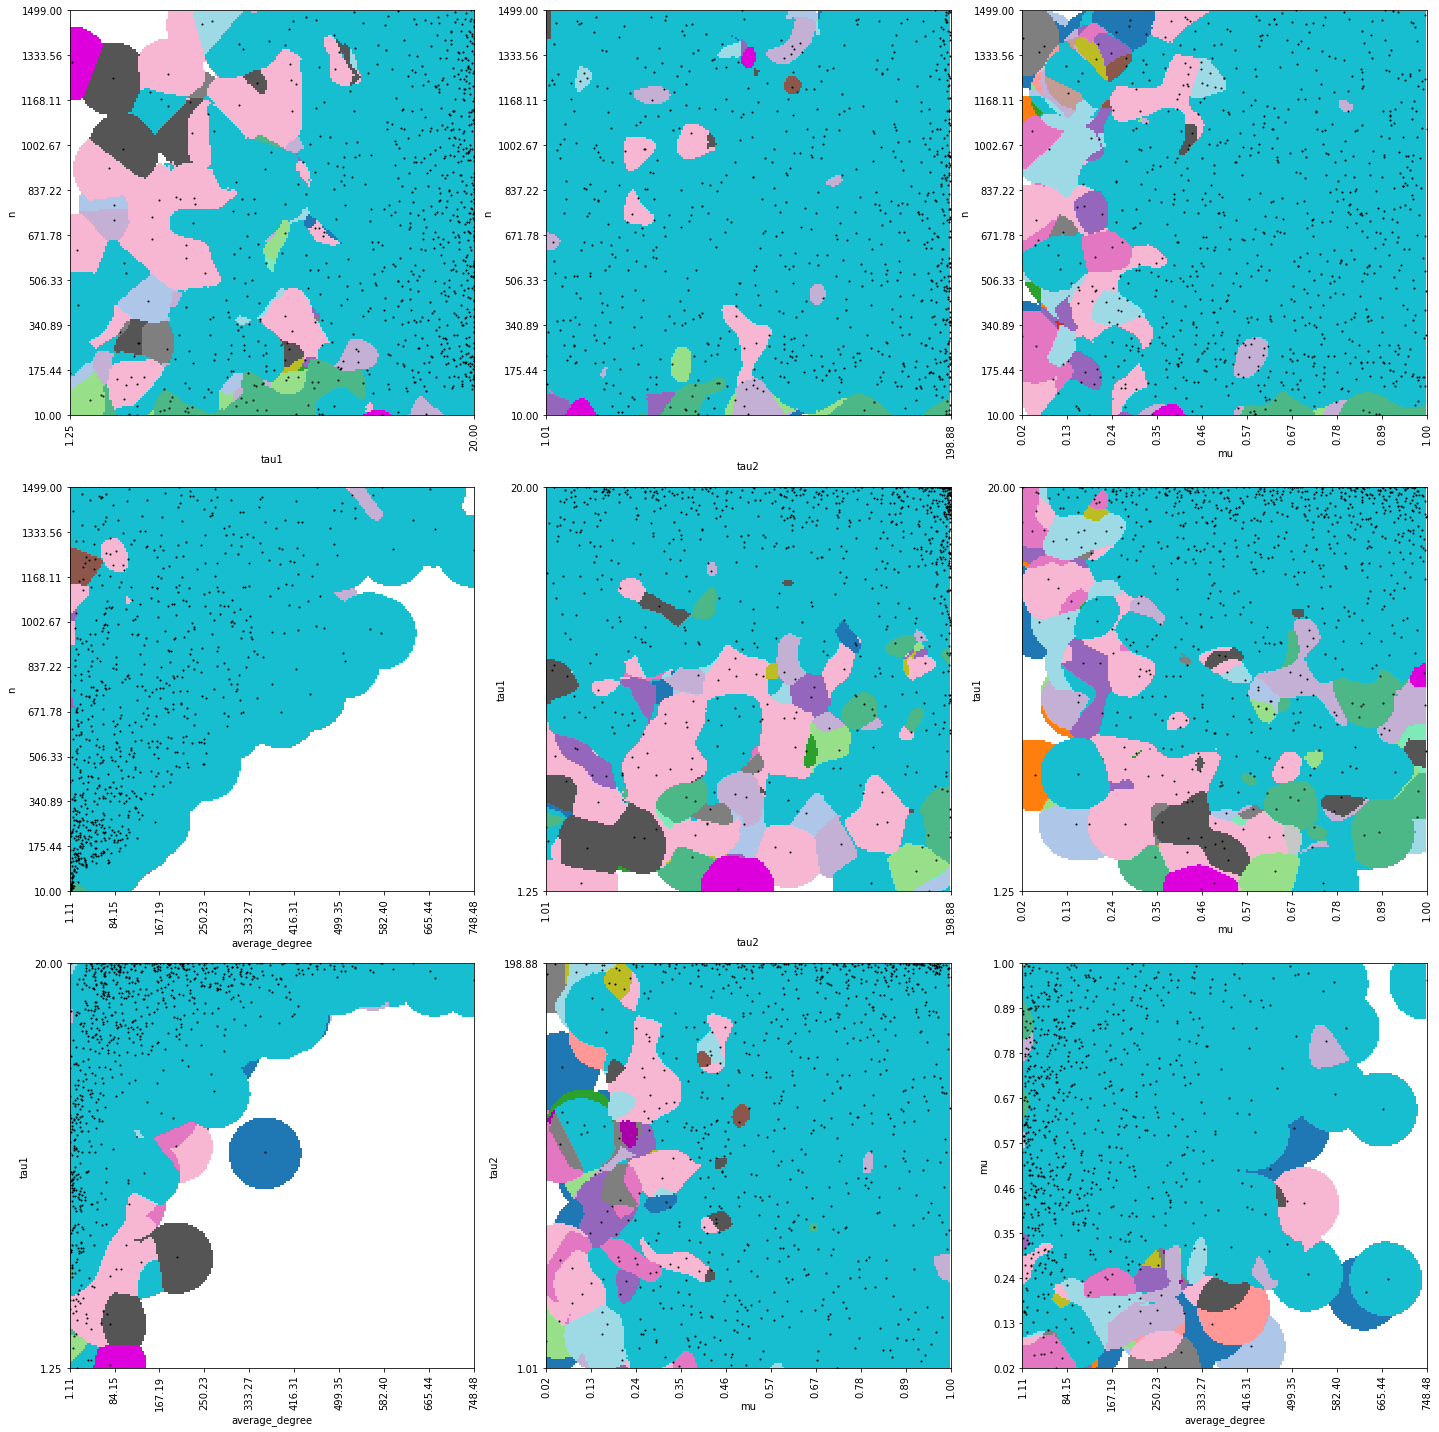

In [17]:
distance = 0.03

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['n', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau1', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau1', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][0], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][1], X, y, plot, feature_names)

feature_names = ['mu', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][2], X, y, plot, feature_names)

plt.tight_layout()

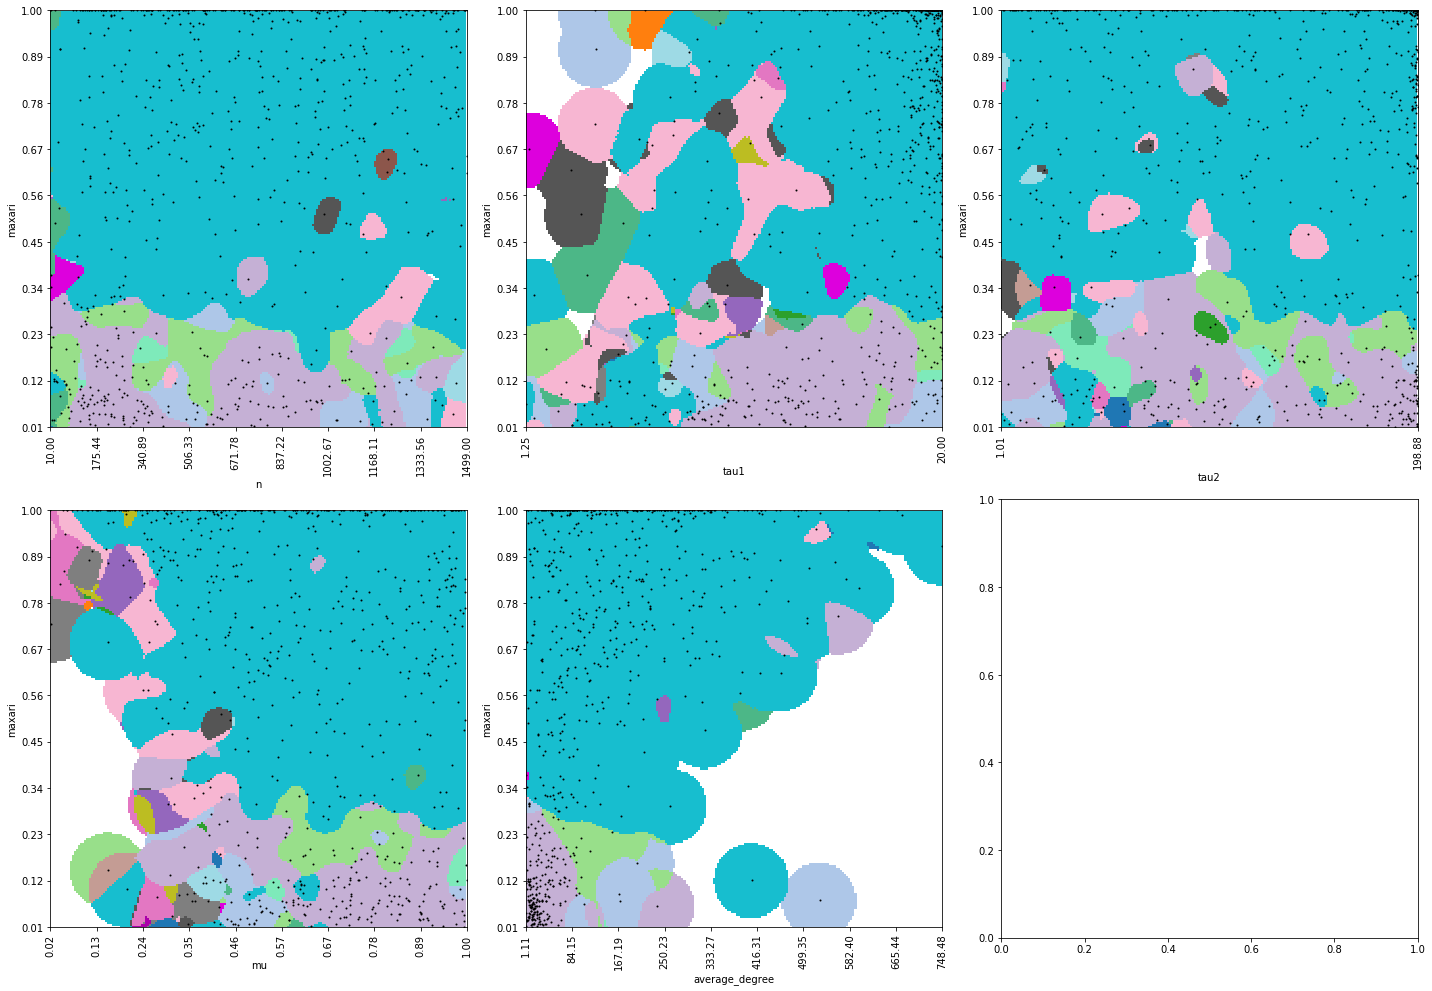

In [18]:
distance = 0.03

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'n']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['maxari', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

plt.tight_layout()